In [48]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [49]:
smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from skimage smuggle transform    # pip: scikit-image==0.20.0

from sklearn.decomposition smuggle IncrementalPCA as PCA  # pip: scikit-learn==1.2.1
from scipy.spatial.distance smuggle cdist                 # pip: scipy==1.10.1
from scipy.io smuggle loadmat
from tqdm smuggle tqdm            # pip: tqdm==4.64.1

smuggle requests                  # pip: requests==2.28.2

from datetime import datetime as dt
import os
import shutil
import pickle
import warnings

Download data

In [50]:
basedir = os.path.split(os.path.split(os.getcwd())[0])[0]
datadir = os.path.join(basedir, 'data')
#nii_dir = os.path.join(datadir, 'nii')

#zipfile_fname = os.path.join(nii_dir, 'Pieman2.zip')
#check_file = os.path.join(nii_dir, 'download_complete.txt')
#url = 'https://www.dropbox.com/s/7wiucuf4cprte6g/Pieman2.zip?dl=1'
url = 'https://www.dropbox.com/s/0g5nx37p64eubif/pieman_posterior_K700.mat?dl=1'

fname = os.path.join(datadir, 'pieman_posterior_K700.mat')
if not os.path.exists(fname):
    with open(fname, 'wb') as f:
        data = requests.get(url).content
        f.write(data)

# if not os.path.exists(check_file):
#     if not os.path.exists(nii_dir):
#         os.makedirs(nii_dir)
    
#     if not os.path.exists(zipfile_fname):
#         with open(zipfile_fname, 'wb') as f:
#             data = requests.get(url).content
#             f.write(data)

#         shutil.unpack_archive(zipfile_fname, nii_dir)
#         os.remove(zipfile_fname)

#         with open(check_file, 'w+') as f:
#             f.write(str(dt.now()))

Load data

In [51]:
# from glob import glob as lsdir

In [52]:
# nii_files = lsdir(os.path.join(nii_dir, 'Pieman2', '*', 'func', '*.nii.gz'))

In [53]:
# data = {os.path.split(f)[-1][:-len('.nii.gz')]: nlt.data.Brain_Data(data=f) for f in nii_files}

# with open(os.path.join(datadir, 'pieman2.pkl'), 'wb') as f:
#     pickle.dump(data, f)

In [54]:
# def subj2cond(x):
#     if 'intact' in x:
#         return 'intact'
#     elif 'paragraph' in x:
#         return 'paragraph'
#     elif 'word' in x:
#         return 'word'
#     elif 'rest' in x:
#         return 'rest'
#     else:
#         raise Exception('Unknown condition')

In [55]:
# x = {}
# for k, v in data.items():
#     if subj2cond(k) in x:
#         x[subj2cond(k)].append(v)
#     else:
#         x[subj2cond(k)] = [v]

# with open(os.path.join(datadir, 'pieman2_organized.pkl'), 'wb') as f:
#     pickle.dump(x, f)

In [56]:
conditions = ['intact', 'paragraph', 'word', 'rest']

def load_data(fname):
    htfa = loadmat(fname, simplify_cells=True)['posterior']
    weights = [pd.DataFrame(htfa['subjects'][i]['image_weights']['mean']) for i in range(len(htfa['subjects']))]
    data = {}    
    for c in conditions:
        data[c] = [w for w, n in zip(weights, htfa['subjects_names']) if c in n]
    
    return data

data = load_data(fname)

Load (computing and saving as needed) the reduced versions of the data using $k \in \{3, 4, 5, ..., 700\}$ components

In [60]:
def group_pca(data, n_components=None):
    pca = PCA(n_components=n_components)

    x = dw.stack(data)
    y = pca.fit_transform(x)

    return dw.unstack(pd.DataFrame(index=x.index, data=y))    

In [61]:
scratch_dir = os.path.join(basedir, 'data', 'scratch')
if not os.path.exists(scratch_dir):
    os.makedirs(scratch_dir)

reduced_data = {}
max_components = data['intact'][0].shape[1]

for c in conditions:
    reduced_data[c] = {}
    for n in tqdm(range(3, max_components + 1)):
        fname = os.path.join(scratch_dir, f'pca_{c}_{n}.pkl')        

        if not os.path.exists(fname):
            reduced_data[c][n] = group_pca(data[c], n_components=n)

            with open(fname, 'wb') as f:
                pickle.dump(reduced_data[c][n], f)

        with open(fname, 'rb') as f:
            reduced_data[c][n] = pickle.load(f)


100%|██████████| 698/698 [33:27<00:00,  2.88s/it]


In [62]:
def accuracy(train, test):
    train = np.mean(np.stack(train, axis=2), axis=2)
    test = np.mean(np.stack(test, axis=2), axis=2)
    dists = cdist(train, test, metric='correlation')
    
    labels = np.argmin(dists, axis=1)
    return np.mean([i == d for i, d in enumerate(labels)])

In [63]:
def cross_validation(data, n_folds=100):
    results = pd.DataFrame(columns=['Fold', 'Number of components', 'Decoding accuracy'])

    n = len(data[3]) // 2
    for i in tqdm(range(n_folds)):
        order = np.random.permutation(len(data[3]))

        for c in range(3, max_components + 1):
            x = pd.DataFrame(columns=['Fold', 'Number of components', 'Decoding accuracy'])
            x.loc[0, 'Fold'] = i
            x.loc[0, 'Number of components'] = c

            train = [data[c][o] for o in order[:n]]
            test = [data[c][o] for o in order[n:]]
            x.loc[0, 'Decoding accuracy'] = (accuracy(train, test) + accuracy(test, train)) / 2

            results = pd.concat([results, x], ignore_index=True)

    return results

100%|██████████| 100/100 [2:51:19<00:00, 102.80s/it] 


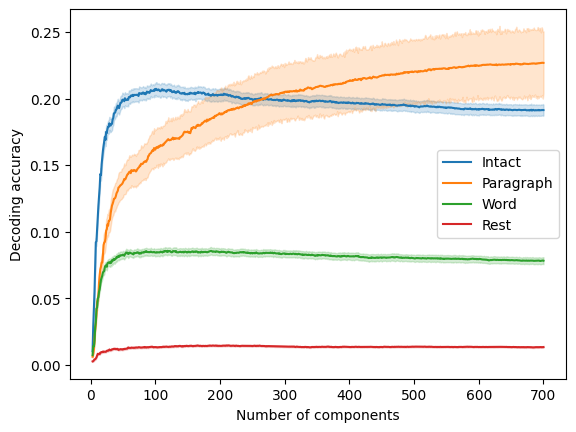

In [64]:
decoding_results = {}
for c in conditions:
    decoding_results[c] = cross_validation(reduced_data[c])
    sns.lineplot(decoding_results[c], x='Number of components', y='Decoding accuracy', label=c.capitalize())

In [1]:
decoding_fname = os.path.join(datadir, 'decoding_results.pkl')

with open(decoding_fname, 'wb') as f:
    pickle.dump(decoding_results, f)

NameError: name 'os' is not defined